# Image alignment

Objetivo alinhar as imagens obtidas nas 4 faixas espectrais para obter uma imagem de 4 canais que representa o objeto e pode ser visualizada como uma imagem de falsa-cor.

![image info](./alignment-visualization.png)

a ideia inicial é usar os [descriptores](https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html).



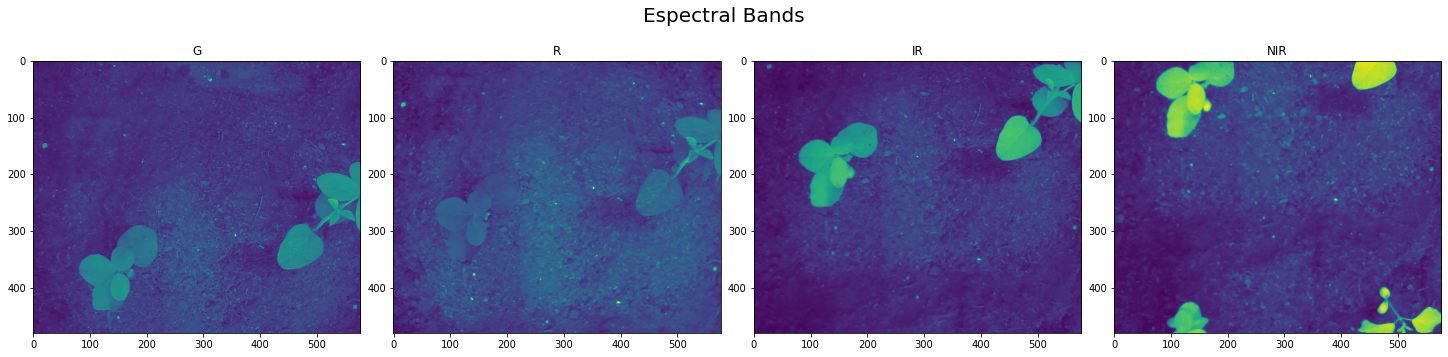

In [1]:
import cv2
import os
import numpy as np
import sys
import matplotlib.pyplot as plt


G   = cv2.imread("imgs/Soja_v3G-01-03.png",  0) 
R   = cv2.imread("imgs/Soja_v3R-01-03.png",  0)
NIR  = cv2.imread("imgs/Soja_v3IR-01-03.png", 0)
IR = cv2.imread("imgs/Soja_v3NIR-01-03.png",0)
RGB = cv2.imread("imgs/Soja_v3RGB-01-03.png")

bands = [G,R,IR,NIR]
names = ["G","R","IR","NIR"]
# Visualização das imagens
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Visualização das imagens normalizadas
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Normalized Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    img = equalize_smooth(img)
    ax.imshow(img)
    ax.set_title(name)

# RGB image for reference
# plt.show()
# plt.imshow(RGB)
# plt.title("RGB")
# plt.show()

# A normalização das imagens facilita a comparação entre as imagens destacando as plantas do backgroud
def equalize_smooth(img):
    """ Histogram Normalization and gaussian blur of input image """
    # img_blur = cv2.GaussianBlur(img, (3,3),0)
    img_blur = cv2.medianBlur(img, 5)
    img_norm = cv2.equalizeHist(img_blur)
    return img_norm

In [2]:
# Selecionar as imagens que vão ser alinhadas:
ir =  equalize_smooth(IR)
rgb = equalize_smooth(G)   

# ir = cv2.GaussianBlur(ir, (1,1),0)
# rgb = cv2.GaussianBlur(rgb, (1,1),0)

# Seleção dos descriptors:
descriptor = cv2.SIFT.create()
# descriptor = cv2.xfeatures2d.SURF_create() #O SURF não é um algoritmo open source e só é incluido no opencv-contrib-python use com cautela.
matcher = cv2.FlannBasedMatcher()

# get features from images
kps_ir, desc_ir = descriptor.detectAndCompute(ir, mask=None)
# gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
gray = rgb
kps_base, desc_base = descriptor.detectAndCompute(gray, mask=None)

# find the corresponding point pairs
if (desc_ir is not None and desc_color is not None and len(desc_ir) >=2 and len(desc_color) >= 2):
    rawMatch = matcher.knnMatch(desc_color, desc_ir, k=2)
    
matches = []
# ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
ratio = 0.75
for m in rawMatch:
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        matches.append((m[0].trainIdx, m[0].queryIdx))
        # print("Train index: ", m[0].trainIdx, "\n Query index", m[0].queryIdx)
        # print()

# convert keypoints to points
pts_ir, pts_color = [], []
for id_ir, id_color in matches:
    pts_ir.append(kps_ir[id_ir].pt)
    pts_color.append(kps_color[id_color].pt)
pts_ir = np.array(pts_ir, dtype=np.float32)
pts_color = np.array(pts_color, dtype=np.float32)

# compute homography
if len(matches) > 4:
#     H, status = cv2.findHomography(pts_ir, pts_color, cv2.RANSAC)
    H, _ = cv2.estimateAffine2D(pts_ir, pts_color)
    H = np.vstack((H, [0, 0, 1]))
    # print("H = ", H)
warped = cv2.warpPerspective(ir, H, (rgb.shape[1], rgb.shape[0]))
# warped = cv2.cvtColor(warped, cv2.COLOR_GRAY2BGR)

In [3]:
# visualize the result
winname = 'result'
cv2.namedWindow(winname, cv2.WINDOW_KEEPRATIO)
alpha = 5
# res = cv2.addWeighted(rgb, 0.5, warped, 0.5, 0)
res = None
def onChange(alpha):
    global rgb, warped, res, winname
    res = cv2.addWeighted(rgb, alpha/5, warped, 1 - alpha/5, 0)
    cv2.imshow(winname, res)
    cv2.imwrite("alignmentR"+ str(alpha) + ".png",res) # Salva as imagens mostradas pelo trackbar

onChange(alpha)
cv2.createTrackbar('alpha', winname, alpha, 5, onChange)
cv2.imshow(winname, res)

cv2.waitKey()
cv2.destroyAllWindows()